In [1]:
import pandas as pd
import numpy as np

weather_path = "../data/au_adelaide_act.csv"
solar_path = "../data/au_sa_iso_satellite_pv_load_act.csv"

# load and store dataset
weather = pd.read_csv(weather_path)
solar = pd.read_csv(solar_path)

# 2. Missing values (-99):
# replace missing values '-99' with NaN
weather.replace(-99, np.nan, inplace = True)
solar.replace(-99, np.nan, inplace = True)

# for 'weather'(au_adelaide_act) dataset, the NaN counts of each column is:
nan_counts_weather = weather.isna().sum()

print("Number of NaN values in each column in weather data:")
print("Row count:", len(weather))
print(nan_counts_weather)

Number of NaN values in each column in weather data:
Row count: 62960
date          0
time          0
tempc         5
cloud8       18
windk         5
wdir          5
humid         5
rainmm       33
radkjm2    6398
dtype: int64


Combine date and time to datetime for both datasets

In [2]:
def to_datetime_df(df):
    date = df['date'].astype('str')
    time = df['time'].astype('str').str.pad(4, fillchar='0')
    df['datetime'] = pd.to_datetime(date + time, format = '%Y%m%d%H%M')
    df_d = df.drop(['date', 'time'], axis = 1)
    return df_d

weather_d = to_datetime_df(weather)
solar_d = to_datetime_df(solar)
solar_d.head()

,load_act,datetime
0,318.991,2018-03-06 09:30:00
1,375.231,2018-03-06 10:00:00
2,430.909,2018-03-06 10:30:00
3,485.129,2018-03-06 11:00:00
4,523.989,2018-03-06 11:30:00


Weather data is hourly, so upsample to 30 minute increments and use linear interpolation to fill values.

In [3]:
weather_resample = weather_d.set_index('datetime').resample('30min').asfreq()
weather_interpolate = weather_resample.interpolate()
weather_interpolate.head()

,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2
datetime,,,,,,,
2016-01-01 00:00:00,27.40,3.0,5.0,80.0,19.0,0.0,NaN
2016-01-01 00:30:00,26.10,5.0,5.0,205.0,27.0,0.0,NaN
2016-01-01 01:00:00,24.80,7.0,5.0,330.0,35.0,0.0,NaN
2016-01-01 01:30:00,24.25,5.5,4.5,315.0,49.0,0.0,NaN
2016-01-01 02:00:00,23.70,4.0,4.0,300.0,63.0,0.0,NaN


Now, join datasets on timestamp, order columns nicely, and ensure post-join sort by datetime.

In [10]:
mix_interpolate = pd.merge(weather_interpolate, solar_d, on='datetime', how='inner', copy=False, validate='1:1')
mix_interpolate = mix_interpolate[['datetime','load_act','tempc','cloud8','windk','wdir','humid','rainmm','radkjm2']]
mix_interpolate.sort_values('datetime', inplace=True)
mix_interpolate.head()

,datetime,load_act,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2
0,2018-03-06 09:30:00,318.991,20.75,2.5,14.5,135.0,44.5,0.0,1915.0
1,2018-03-06 10:00:00,375.231,21.50,1.0,16.0,140.0,40.0,0.0,2340.0
2,2018-03-06 10:30:00,430.909,22.25,1.5,15.5,145.0,37.0,0.0,2570.0
3,2018-03-06 11:00:00,485.129,23.00,2.0,15.0,150.0,34.0,0.0,2800.0
4,2018-03-06 11:30:00,523.989,23.55,2.0,13.0,145.0,32.0,0.0,2945.0


Plot all values against timestamp for visual confirmation of success.

array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>], dtype=object)

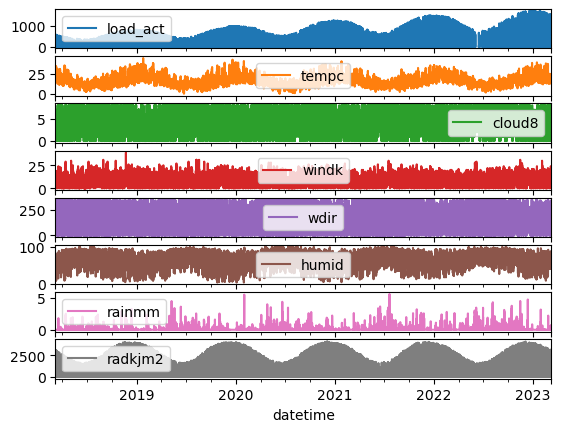

In [5]:
mix_interpolate.plot(x='datetime', subplots=True)

Looks good enough - write to file.

In [6]:
mix_interpolate.to_csv('../data/weather_solar_interpolate.csv', index=False)